In [4]:
import tensorflow as tf
import numpy as np

In [20]:
def dist_euclid(X, Z):
    X_norm = tf.reshape(tf.reduce_sum(tf.square(X),axis=1), [-1,1])
    Z_norm = tf.reshape(tf.reduce_sum(tf.square(Z), axis=1), [1,-1])
    dist = X_norm + Z_norm - 2*tf.matmul(X,tf.transpose(Z))
    return dist

In [59]:
def responsibility_matrix(X, X_test, k):
    neg_dist = tf.negative(dist_euclid(X_test, X))
    k_nearest_values, k_nearest_indices = tf.nn.top_k(neg_dist, k=k, sorted=True, name='k_nearest')
    r_mat_shape = (X.shape[0], X_test.shape[0])
    sparse_r_mat = tf.SparseTensor(indices=k_nearest_indices, values=1/k, dense_shape=r_mat_shape)
    r_mat = tf.add(tf.zeros(shape=r_mat_shape), sparse_r_mat, name="r_mat")
    return r_mat

In [71]:
def k_nearest_neighbours(X, X_test, k):
    neg_dist = tf.negative(dist_euclid(X_test, X))
    k_nearest_values, k_nearest_indices = tf.nn.top_k(neg_dist, k=k, sorted=True, name='k_nearest')
    return k_nearest_values, k_nearest_indices

In [78]:
def knn_predict(X, y, X_pred, k):
    #r_mat = responsibility_matrix(X, X_pred, k)
    _, k_nearest_indices = k_nearest_neighbours(X, X_pred, k)
    k_nearest_y = tf.gather(y, indices=k_nearest_indices, name='k_nearest_y')
    y_pred = tf.reduce_mean(k_nearest_y, axis=1)
    #y_pred = tf.matmul(tf.transpose(r_mat), y)
    return y_pred

In [93]:
np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

In [114]:
knn = tf.Graph()
with knn.as_default():
    X = tf.placeholder(dtype=tf.float32, name='X')
    y = tf.placeholder(dtype=tf.float32, name='y')

    k = tf.placeholder(dtype=tf.int32, name='k')
    
    y_true = tf.placeholder(dtype=tf.float32, name='y_true')
    
    with tf.name_scope('predictions'):
        X_pred = tf.placeholder(dtype=tf.float32, name='X_pred')
        y_pred = knn_predict(X, y, X_pred, k)
    
    with tf.name_scope('mse_loss'):
        loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

In [115]:
test_X = np.array([[1], [3], [4], [6], [7], [8]])
test_y = np.array([[1], [2], [3], [4], [5], [6]])
test_X_pred = np.array([[2], [5], [6], [1.2], [7.5]])
test_k = 2
test_y_true = np.array([[1.5], [2.5], [6.5], [1.5], [6]])

with knn.as_default():
    _, indices = k_nearest_neighbours(X, X_pred, k)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        print(sess.run(indices, feed_dict={X: test_X, y: test_y, X_pred: test_X_pred, k: test_k}))
        print(sess.run(y_pred, feed_dict={X: test_X, y: test_y, X_pred: test_X_pred, k: test_k}))
        print(sess.run(loss, feed_dict={X: test_X, y: test_y, X_pred: test_X_pred, k: test_k, y_true: test_y_true}))

[[0 1]
 [2 3]
 [3 4]
 [0 1]
 [4 5]]
[[1.5]
 [3.5]
 [4.5]
 [1.5]
 [5.5]]
1.05



For k = 1:
For the train set:
0.0
For the validation set:
0.5430993
For the test set:
0.29381403


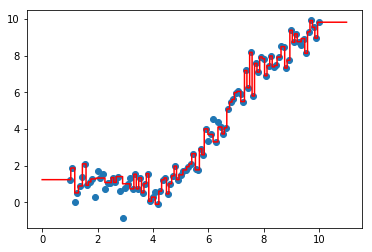


For k = 3:
For the train set:
0.21161315
For the validation set:
0.6486066
For the test set:
0.2643815


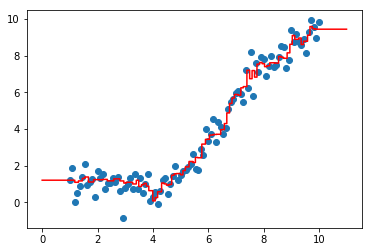


For k = 5:
For the train set:
0.26088637
For the validation set:
0.58346236
For the test set:
0.35648388


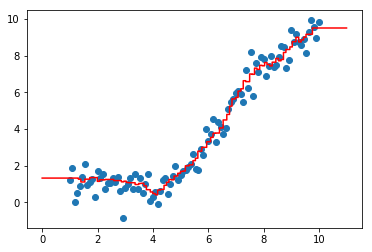


For k = 50:
For the train set:
2.493421
For the validation set:
2.4460893
For the test set:
1.4052633


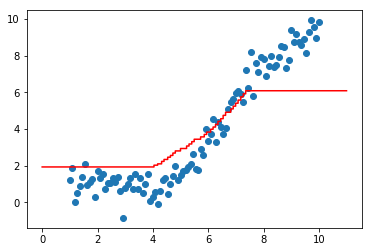

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

data_set = (trainData, validData, testData)
target_set = (trainTarget, validTarget, testTarget)
set_names = ("train", "validation", "test")
k_list = (1, 3, 5, 50)

with knn.as_default():
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        for K in k_list:
            print("\nFor k = {}:".format(K))
            for data, target, name in zip(data_set, target_set, set_names):
                print("For the {} set:".format(name))
                error = sess.run(loss, feed_dict={X: trainData, y: trainTarget, X_pred: data, y_true: target, k: K})
                print(error)
            X_Data = np.linspace(0.0, 11.0, num=1000)[:,np.newaxis]
            
            Pred = (sess.run(y_pred, feed_dict={X: trainData, y: trainTarget, X_pred: X_Data, k: K}))
            plt.scatter(x=Data, y=Target)
            plt.step(x=X_Data, y=Pred,c='r')
            plt.show()